# 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas
import konlpy
import gensim

### 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 분석할 데이터 준비
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jmson/aiffel/sentiment_classification/data/ratings_train.txt'

### 2) 데이터로더 구성

In [9]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000): # 데이터 전처리 후 반환하는 함수
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train= []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>','<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) # 데이터 준비 완료

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 단어 인덱스 리스트 벡터로 반환함
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 단어 인덱스 리스트 벡터로 encode 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장들을 decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

max len:  116
mean len:  15.98170773419436


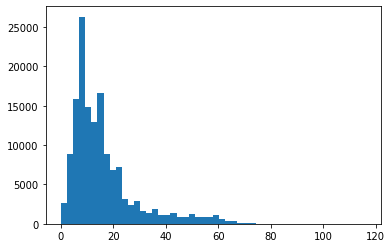

In [6]:
import matplotlib.pyplot as plt

print('max len: ', max(len(review) for review in X_train)) # 데이터셋 내 최대 문장 길이
print('mean len: ', sum(map(len, X_train))/len(X_train)) # 데이터셋 문장 길이 평균
plt.hist([len(review) for review in X_train], bins=50)
plt.show() # 문장 길이 분포 확인

In [7]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count += 1
    print(f'최대 길이: {max_len}, 커버 가능한 샘플 비율: {(count/len(nested_list))*100}')

In [8]:
below_threshold_len(50, X_train) # 최대 길이 50일 때 96퍼센트의 샘플 커버 가능

최대 길이: 50, 커버 가능한 샘플 비율: 96.03439547960761


In [9]:
import tensorflow as tf
# 최대 문장 길이 50으로 결정
# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='pre',maxlen=50)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='pre',maxlen=50)

### 4) 모델 구성 및 validation set 구성

#### (1) LSTM

In [10]:
# LSTM 모델 준비
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000 
word_vector_dim = 50 
hidden_units = 30

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, word_vector_dim))
model_lstm.add(LSTM(hidden_units))
model_lstm.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # val_loss가 4번 떨어지면 학습 멈춤
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 30)                9720      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 509,751
Trainable params: 509,751
Non-trainable params: 0
_________________________________________________________________


#### (2) GRU

In [11]:
# GRU 모델 준비
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size=10000
word_vector_dim = 50
hidden_units = 30

model_gru = Sequential()
model_gru.add(Embedding(vocab_size, word_vector_dim))
model_gru.add(GRU(hidden_units))
model_gru.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
gru (GRU)                    (None, 30)                7380      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 507,411
Trainable params: 507,411
Non-trainable params: 0
_________________________________________________________________


#### (3) 1D CNN

In [12]:
# 1D CNN 모델 준비
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000
word_vector_dim_cnn = 16

model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, word_vector_dim_cnn))
model_cnn.add(Conv1D(16, 7, activation='relu'))
model_cnn.add(MaxPooling1D(5))
model_cnn.add(Conv1D(16, 7, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True,\
                                                 stratify=y_train, random_state=1234)

### 5) 모델 훈련 개시

#### (1) LSTM

In [14]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512,\
                    validation_data=(X_val, y_val), verbose=1) # LSTM 훈련

Epoch 1/15
215/215 [==============================] - 5s 9ms/step - loss: 0.4616 - accuracy: 0.7891 - val_loss: 0.3641 - val_accuracy: 0.8411
Epoch 2/15
215/215 [==============================] - 1s 6ms/step - loss: 0.3296 - accuracy: 0.8595 - val_loss: 0.3472 - val_accuracy: 0.8485
Epoch 3/15
215/215 [==============================] - 1s 6ms/step - loss: 0.3023 - accuracy: 0.8724 - val_loss: 0.3694 - val_accuracy: 0.8404
Epoch 4/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2835 - accuracy: 0.8810 - val_loss: 0.3463 - val_accuracy: 0.8500
Epoch 5/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2638 - accuracy: 0.8901 - val_loss: 0.3556 - val_accuracy: 0.8513
Epoch 6/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2438 - accuracy: 0.8990 - val_loss: 0.3573 - val_accuracy: 0.8482
Epoch 7/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2259 - accuracy: 0.9071 - val_loss: 0.3753 - val_accuracy: 0.8497
Epoch 

In [15]:
result_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
print(result_lstm) # LSTM 결과

1537/1537 - 3s - loss: 0.4019 - accuracy: 0.8462
[0.4018649756908417, 0.8462274074554443]


#### (2) GRU

In [16]:
history_gru = model_gru.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512, \
                        validation_data=(X_val, y_val), verbose=1) # GRU 훈련

Epoch 1/15
215/215 [==============================] - 3s 8ms/step - loss: 0.4472 - accuracy: 0.7914 - val_loss: 0.3612 - val_accuracy: 0.8427
Epoch 2/15
215/215 [==============================] - 1s 6ms/step - loss: 0.3301 - accuracy: 0.8598 - val_loss: 0.3565 - val_accuracy: 0.8460
Epoch 3/15
215/215 [==============================] - 1s 7ms/step - loss: 0.3102 - accuracy: 0.8697 - val_loss: 0.3528 - val_accuracy: 0.8470
Epoch 4/15
215/215 [==============================] - 1s 7ms/step - loss: 0.2966 - accuracy: 0.8754 - val_loss: 0.3603 - val_accuracy: 0.8476
Epoch 5/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2826 - accuracy: 0.8826 - val_loss: 0.3517 - val_accuracy: 0.8506
Epoch 6/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2661 - accuracy: 0.8906 - val_loss: 0.3617 - val_accuracy: 0.8513
Epoch 7/15
215/215 [==============================] - 1s 6ms/step - loss: 0.2486 - accuracy: 0.8990 - val_loss: 0.3596 - val_accuracy: 0.8517
Epoch 

In [17]:
result_gru = model_gru.evaluate(X_test, y_test, verbose=2)
print(result_gru) # GRU 결과

1537/1537 - 3s - loss: 0.3858 - accuracy: 0.8461
[0.3858424425125122, 0.8461053371429443]


#### (3) 1D CNN

In [18]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=15, callbacks=es, batch_size=512, \
                        validation_data=(X_val, y_val), verbose=1) # 1D CNN 훈련

Epoch 1/15
215/215 [==============================] - 3s 6ms/step - loss: 0.5960 - accuracy: 0.6624 - val_loss: 0.4830 - val_accuracy: 0.7567
Epoch 2/15
215/215 [==============================] - 1s 5ms/step - loss: 0.4473 - accuracy: 0.7790 - val_loss: 0.4609 - val_accuracy: 0.7689
Epoch 3/15
215/215 [==============================] - 1s 5ms/step - loss: 0.4126 - accuracy: 0.7976 - val_loss: 0.4597 - val_accuracy: 0.7717
Epoch 4/15
215/215 [==============================] - 1s 5ms/step - loss: 0.3875 - accuracy: 0.8110 - val_loss: 0.4656 - val_accuracy: 0.7705
Epoch 5/15
215/215 [==============================] - 1s 5ms/step - loss: 0.3616 - accuracy: 0.8253 - val_loss: 0.4776 - val_accuracy: 0.7692
Epoch 6/15
215/215 [==============================] - 1s 5ms/step - loss: 0.3322 - accuracy: 0.8425 - val_loss: 0.5007 - val_accuracy: 0.7599
Epoch 7/15
215/215 [==============================] - 1s 5ms/step - loss: 0.3030 - accuracy: 0.8564 - val_loss: 0.5321 - val_accuracy: 0.7627
Epoch 

In [19]:
result_cnn = model_cnn.evaluate(X_test, y_test, verbose=2)
print(result_cnn) #1D CNN 결과

1537/1537 - 3s - loss: 0.5282 - accuracy: 0.7617
[0.5281824469566345, 0.761702299118042]


### 6) Loss, Accuracy 그래프 시각화

In [ ]:
def show_loss_acc(history_model, show): # epoch에 따라 증감하는 accuracy, loss 시각화
    history_dict = history_model.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    if show == 'acc':
        show = acc
        val_show = val_acc
    else:
        show = loss
        val_show = val_loss

    plt.plot(epochs, show, 'bo', label='Training loss')
    plt.plot(epochs, val_show, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

#### (1) LSTM

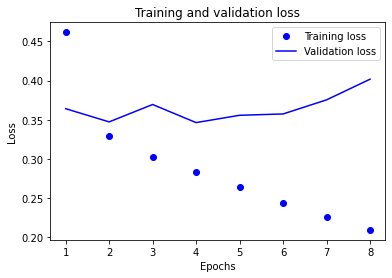

In [21]:
show_loss_acc(history_lstm)

#### (2) GRU

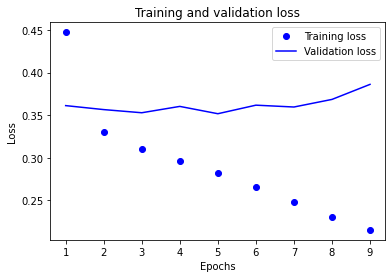

In [22]:
show_loss_acc(history_gru)

#### (3) CNN

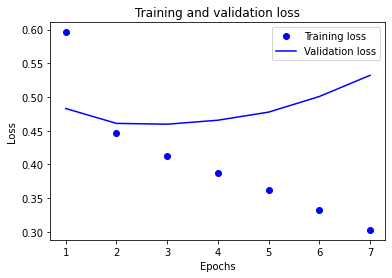

In [23]:
show_loss_acc(history_cnn)

### 7) 학습된 Embedding 레이어 분석

#### (1) LSTM

In [24]:
import os 
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 50)


In [66]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['눈물']
vector

array([-0.10338707, -0.09272889, -0.07954173, -0.06722962, -0.08293702,
       -0.0221831 ,  0.09565692,  0.13618015,  0.07182993,  0.11074545,
        0.05544777, -0.14621629, -0.1247906 ,  0.0826328 , -0.05834436,
        0.07176371,  0.07454565, -0.06764479,  0.08570617,  0.0797506 ,
        0.10930809,  0.07361075,  0.11297198,  0.14133841,  0.11338778,
       -0.09444339,  0.06530226, -0.08984935,  0.0489859 , -0.11216385,
       -0.10423142, -0.05931703,  0.07993412,  0.14629062, -0.03407083,
       -0.12134437,  0.04053222,  0.09212717,  0.11698933, -0.11145418,
       -0.08363123,  0.08711222,  0.07835259, -0.07228428, -0.08384022,
        0.1060757 , -0.10100158,  0.1202772 ,  0.1346255 , -0.05037095],
      dtype=float32)

In [67]:
word_vectors.similar_by_word('눈물')

[('굿', 0.9430440664291382),
 ('ㅠㅠㅠㅠ', 0.939810037612915),
 ('으뜸', 0.9385641813278198),
 ('탁월', 0.9360297322273254),
 ('전율', 0.9357385039329529),
 ('빠져', 0.9335129261016846),
 ('최고', 0.9311909079551697),
 ('앓', 0.9307574033737183),
 ('이제서야', 0.9297536611557007),
 ('멋져요', 0.928886890411377)]

#### (2) GRU

In [27]:
import os 
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_gru.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path_gru = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gru.txt'
f = open(word2vec_file_path_gru, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model_gru.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 50)


In [68]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gru, binary=False)
vector = word_vectors['눈물']
vector

array([ 0.12693708,  0.14176683,  0.12311012, -0.02533282,  0.09545334,
        0.0765553 ,  0.02470577,  0.10983959,  0.05899293, -0.07785632,
        0.08395557, -0.1007695 ,  0.08179231,  0.13724278,  0.08949124,
        0.01808309,  0.07286359, -0.03362349, -0.07429541, -0.0768572 ,
        0.10928863,  0.09094515, -0.10956294,  0.04425193, -0.11595646,
       -0.08003119,  0.13051414, -0.05693857, -0.07573619, -0.0635351 ,
       -0.07513034, -0.07884769,  0.06944908, -0.08177596, -0.04120137,
       -0.12719034,  0.09661915,  0.10201462, -0.13153037,  0.07441767,
       -0.0493964 , -0.0977996 , -0.08618743,  0.06115859, -0.09716722,
       -0.04700529, -0.0658942 , -0.01276191,  0.0447739 ,  0.08218557],
      dtype=float32)

In [69]:
word_vectors.similar_by_word('눈물')

[('더한', 0.9601083397865295),
 ('무덤덤', 0.9533775448799133),
 ('It', 0.9492419362068176),
 ('리암니슨', 0.948829174041748),
 ('극대', 0.9464994668960571),
 ('해학', 0.9460211992263794),
 ('보복', 0.9448063373565674),
 ('겸손', 0.943171501159668),
 ('두고두고', 0.941153347492218),
 ('각지', 0.9407122135162354)]

#### (3) 1D CNN

In [30]:
import os 
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim_cnn)) 

vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [70]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
vector = word_vectors['눈물']
vector

array([ 0.08393544,  0.1492883 , -0.05195571, -0.05479405, -0.12365288,
        0.02026335, -0.04435963, -0.04204091, -0.10297357,  0.13234288,
        0.06048306,  0.01636155,  0.16912337,  0.08014829, -0.09969768,
        0.10210065], dtype=float32)

In [71]:
word_vectors.similar_by_word('눈물')

[('17', 0.9409992694854736),
 ('웃긴데', 0.9383087754249573),
 ('곳', 0.9154172539710999),
 ('하루하루', 0.896135151386261),
 ('결합', 0.8883051872253418),
 ('덜덜', 0.8824495673179626),
 ('톰크루즈', 0.881274402141571),
 ('ㅠㅠㅠ', 0.8795425295829773),
 ('불패', 0.8772687911987305),
 ('풍성', 0.8759429454803467)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path =os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['눈물']
vector

In [73]:
word2vec.wv.similar_by_word('눈물')

[('웃음', 0.7543492317199707),
 ('슬픔', 0.7267216444015503),
 ('한숨', 0.7182712554931641),
 ('피눈물', 0.7141152024269104),
 ('땀', 0.7121106386184692),
 ('이별', 0.695806622505188),
 ('가슴', 0.6698150038719177),
 ('기쁨', 0.657920241355896),
 ('머리카락', 0.6576725840568542),
 ('꿈', 0.6558417677879333)]

In [63]:
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]
        
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100
hidden_units = 200

model = Sequential()
model.add(Embedding(vocab_size, 
                         word_vector_dim, 
                         embeddings_initializer=Constant(embedding_matrix),
                         input_length=50,
                         trainable=True))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 1,241,001
Trainable params: 1,241,001
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(X_train, y_train, epochs=20, callbacks=es, batch_size=256,\
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
429/429 [==============================] - 8s 15ms/step - loss: 0.4408 - accuracy: 0.7914 - val_loss: 0.3656 - val_accuracy: 0.8367
Epoch 2/20
429/429 [==============================] - 6s 14ms/step - loss: 0.3217 - accuracy: 0.8597 - val_loss: 0.3301 - val_accuracy: 0.8548
Epoch 3/20
429/429 [==============================] - 6s 14ms/step - loss: 0.2746 - accuracy: 0.8834 - val_loss: 0.3215 - val_accuracy: 0.8592
Epoch 4/20
429/429 [==============================] - 6s 14ms/step - loss: 0.2369 - accuracy: 0.9022 - val_loss: 0.3235 - val_accuracy: 0.8636
Epoch 5/20
429/429 [==============================] - 6s 14ms/step - loss: 0.2033 - accuracy: 0.9183 - val_loss: 0.3461 - val_accuracy: 0.8579
Epoch 6/20
429/429 [==============================] - 6s 14ms/step - loss: 0.1676 - accuracy: 0.9345 - val_loss: 0.3693 - val_accuracy: 0.8610
Epoch 7/20
429/429 [==============================] - 6s 14ms/step - loss: 0.1333 - accuracy: 0.9486 - val_loss: 0.4124 - val_accuracy: 0.8554

In [65]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 4s - loss: 0.4068 - accuracy: 0.8557
